### Installing Shap explainer

In [6]:
pip install shap

  Using cached shap-0.45.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (540 kB)
  Using cached slicer-0.0.8-py3-none-any.whl (15 kB)


In [7]:
import pandas as pd
import transformers

import shap

### Importing dataset to pandas dataframe

In [10]:

data=pd.read_csv('/content/dataset_small.csv')
data.shape

(199, 3)

In [11]:
# Renaming columns
data = data.rename(columns={'Label':'Rating'})
data = data.rename(columns={'CourseId':'CourseName'})
data.head()

,CourseName,Review,Rating
0,2-speed-it,I was disappointed because the name is mislead...,3
1,2-speed-it,Videos that are presented in French could've b...,4
2,2-speed-it,"Excellent course, for me it was very rewarding...",5
3,2-speed-it,Super content. I'll definitely re-do the course,5
4,2-speed-it,Etant contrÃ´leur de gestion pour le dÃ©partem...,5


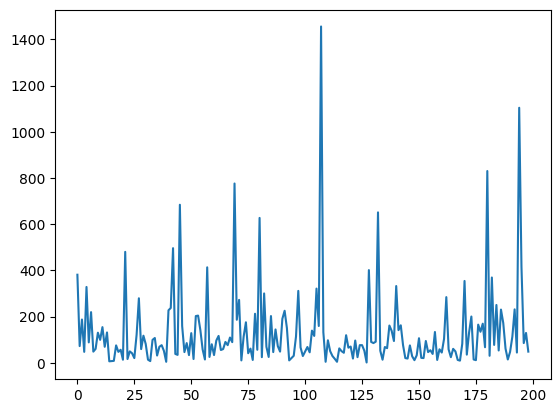

In [35]:
# Plotting word lenghts of reviews
data['Review'] = data['Review'].astype(str)
word_length = [len(x) for x in data['Review']]
plt.plot(word_length)

#### Ploting classes to class distribution. As we can see dataset is highly imbalance

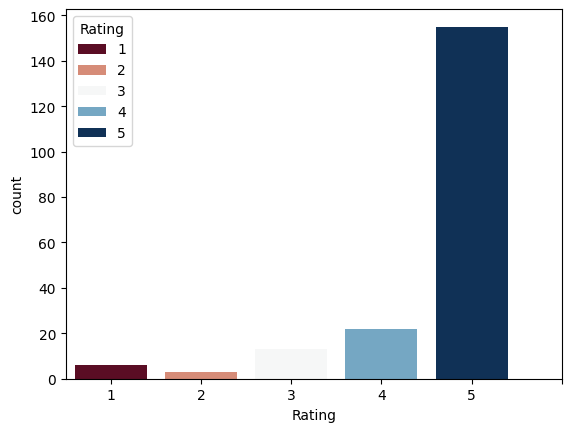

In [36]:
sns.countplot(x=data['Rating'], data=data, hue=data['Rating'], palette='RdBu', dodge=False)
plt.xticks([0,1,2,3,4,5])
plt.show()

#### Applying Random over sampling technique to balance classes

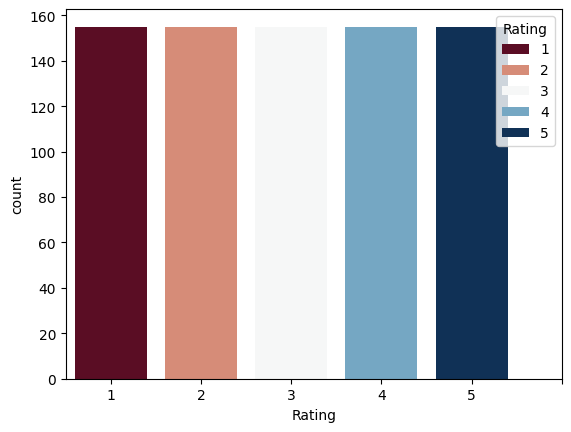

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='all')
# fit and apply the transform
#X = data.drop(columns=['Rating','CourseName'])
X = data[['Review']]
y = data['Rating']
X_over, y_over = oversample.fit_resample(X, y)
sns.countplot(x=y_over, data=data, hue=y_over, palette='RdBu', dodge=False)
plt.xticks([0,1,2,3,4,5])
plt.show()

In [15]:
#Combining oversampled columns to create dataframe
data_over = pd.concat([X_over, y_over], axis=1)

In [16]:
data_over.shape

(775, 2)

In [17]:
data_over.head()

,Review,Rating
0,I was disappointed because the name is mislead...,3
1,Videos that are presented in French could've b...,4
2,"Excellent course, for me it was very rewarding...",5
3,Super content. I'll definitely re-do the course,5
4,Etant contrÃ´leur de gestion pour le dÃ©partem...,5


In [18]:
pip install transformers_interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x

#### Importing BERT pretrained emotion Classifier

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

model_name = 'nateraw/bert-base-uncased-emotion'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#### Predicting emotions for each review

In [20]:
def predict_sentiment(sequence):
  # Apply tokenization on our input sentence
  inputs = tokenizer(sequence, return_tensors='pt')
  # Do the prediction and save the logits
  logits = model(**inputs).logits
  # Find the class (Positive, Neutral, or Negative) which has the highest probability
  predicted_class_id = logits.argmax().item()
  # Return the predicted class
  return(model.config.id2label[predicted_class_id])

# Call predict_sentiment for all sentences
data_over['Sentiment'] = data_over['Review'].apply(lambda Review: predict_sentiment(Review))
# The lambda function used here is a Pythonic approach to write an anonymous function
# and it can take any number of arguments.

In [24]:
data_over.head()

,Review,Rating,Sentiment
0,I was disappointed because the name is mislead...,3,sadness
1,Videos that are presented in French could've b...,4,joy
2,"Excellent course, for me it was very rewarding...",5,joy
3,Super content. I'll definitely re-do the course,5,joy
4,Etant contrÃ´leur de gestion pour le dÃ©partem...,5,joy


In [22]:
data_over['Sentiment'].unique()

array(['sadness', 'joy', 'love', 'anger', 'surprise'], dtype=object)

In [25]:
from transformers_interpret import SequenceClassificationExplainer

In [26]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

In [27]:
word_attributions = cls_explainer(data_over['Review'][0])
cls_explainer.visualize()

In [29]:
word_attributions = cls_explainer(data_over['Review'][2])
cls_explainer.visualize()

In [33]:
word_attributions = cls_explainer(data_over['Review'][9])
cls_explainer.visualize()

In [34]:
word_attributions = cls_explainer(data_over['Review'][5])
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,joy (0.99),joy,1.29,[CLS] one of the excellent courses at course ##ra for information technology bosses and managers . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,joy (0.99),joy,1.29,[CLS] one of the excellent courses at course ##ra for information technology bosses and managers . [SEP]
